In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

%matplotlib inline 

import _init_paths
import os
import sys
print(sys.version)
import numpy as np
import argparse
import pprint
import pdb
import time
import cv2
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.datasets as dset
from scipy.misc import imread

from model.utils.config import cfg, cfg_from_file, cfg_from_list, get_output_dir
from model.rpn.bbox_transform import clip_boxes
from model.nms.nms_wrapper import nms
from model.rpn.bbox_transform import bbox_transform_inv
from model.utils.net_utils import save_net, load_net, vis_detections
from model.utils.blob import im_list_to_blob
from model.faster_rcnn.vgg16 import vgg16
from model.faster_rcnn.resnet import resnet
from roi_data_layer.roidb import combined_roidb
from roi_data_layer.roibatchLoader import roibatchLoader
import pdb
torch.cuda.empty_cache()
try:
	xrange          # Python 2
except NameError:
	xrange = range  # Python 3

2.7.12 (default, Nov 12 2018, 14:36:49) 
[GCC 5.4.0 20160609]


/usr/local/lib/python2.7/dist-packages/requests/__init__.py:83: RequestsDependencyWarning: Old version of cryptography ([1, 2, 3]) may cause slowdown.
  warnings.warn(warning, RequestsDependencyWarning)


In [2]:
def _get_image_blob(im):
    
    """
    Converts an image into a network input.
    Arguments:
    im (ndarray): a color image in BGR order
    Returns:
    blob (ndarray): a data blob holding an image pyramid
    im_scale_factors (list): list of image scales (relative to im) used
      in the image pyramid
    """
    im_orig = im.astype(np.float32, copy=True)
    im_orig -= cfg.PIXEL_MEANS

    im_shape = im_orig.shape
    im_size_min = np.min(im_shape[0:2])
    im_size_max = np.max(im_shape[0:2])

    processed_ims = []
    im_scale_factors = []

    for target_size in cfg.TEST.SCALES:
        im_scale = float(target_size) / float(im_size_min)
        # Prevent the biggest axis from being more than MAX_SIZE
        if np.round(im_scale * im_size_max) > cfg.TEST.MAX_SIZE:
            im_scale = float(cfg.TEST.MAX_SIZE) / float(im_size_max)
        im = cv2.resize(im_orig, None, None, fx=im_scale, fy=im_scale,
                interpolation=cv2.INTER_LINEAR)
        im_scale_factors.append(im_scale)
        processed_ims.append(im)

      # Create a blob to hold the input images
    blob = im_list_to_blob(processed_ims)

    return blob, np.array(im_scale_factors)

In [3]:
def process_image(im_in):
    
    torch.cuda.empty_cache()
    total_tic = time.time()
    if len(im_in.shape) == 2:
        im_in = im_in[:,:,np.newaxis]
        im_in = np.concatenate((im_in,im_in,im_in), axis=2)
    im_in = im_in[:,:,::-1]
    im = cv2.cvtColor(im_in, cv2.COLOR_RGB2BGR)

    blobs, im_scales = _get_image_blob(im)
    im_blob = blobs
    im_info_np = np.array([[im_blob.shape[1], im_blob.shape[2], im_scales[0]]], dtype=np.float32)

    im_data_pt = torch.from_numpy(im_blob)
    im_data_pt = im_data_pt.permute(0, 3, 1, 2)
    im_info_pt = torch.from_numpy(im_info_np)

    im_data.data.resize_(im_data_pt.size()).copy_(im_data_pt)
    im_info.data.resize_(im_info_pt.size()).copy_(im_info_pt)
    gt_boxes.data.resize_(1, 1, 5).zero_()
    num_boxes.data.resize_(1).zero_()

    det_tic = time.time()

    rois, cls_prob, bbox_pred, \
    rpn_loss_cls, rpn_loss_box, \
    RCNN_loss_cls, RCNN_loss_bbox, \
    rois_label = fasterRCNN(im_data, im_info, gt_boxes, num_boxes)

    scores = cls_prob.data
    boxes = rois.data[:, :, 1:5]

    if cfg.TEST.BBOX_REG:
        box_deltas = bbox_pred.data
        if cfg.TRAIN.BBOX_NORMALIZE_TARGETS_PRECOMPUTED:
            box_deltas = box_deltas.view(-1, 4) * torch.FloatTensor(cfg.TRAIN.BBOX_NORMALIZE_STDS).cuda() \
                                   + torch.FloatTensor(cfg.TRAIN.BBOX_NORMALIZE_MEANS).cuda()
            box_deltas = box_deltas.view(1, -1, 4 * len(coco_classes))
        pred_boxes = bbox_transform_inv(boxes, box_deltas, 1)
        pred_boxes = clip_boxes(pred_boxes, im_info.data, 1)
    else:
        _ = torch.from_numpy(np.tile(boxes, (1, scores.shape[1])))
        pred_boxes = _.cuda()

    pred_boxes /= im_scales[0]

    scores = scores.squeeze()
    pred_boxes = pred_boxes.squeeze()
    det_toc = time.time()
    detect_time = det_toc - det_tic
    misc_tic = time.time()

    im2show = np.copy(im)
    cls_seen = []
    for j in xrange(1, len(coco_classes)):
        inds = torch.nonzero(scores[:,j]>thresh).view(-1)
        if inds.numel() > 0:
            cls_scores = scores[:,j][inds]
            _, order = torch.sort(cls_scores, 0, True)
            cls_boxes = pred_boxes[inds][:, j * 4:(j + 1) * 4]

            cls_dets = torch.cat((cls_boxes, cls_scores.unsqueeze(1)), 1)
            cls_dets = cls_dets[order]
            keep = nms(cls_dets, cfg.TEST.NMS, force_cpu=not cfg.USE_GPU_NMS)
            cls_dets = cls_dets[keep.view(-1).long()]
            im2show = vis_detections(im2show, coco_classes[j], cls_dets.cpu().numpy(), 0.5)
            cls_seen.append(cls_scores)

    return im2show

In [11]:

total_time = 0
total_frames = 0

def process_frame(im_in):
    
    global total_time
    global total_frames
    
    total_tic = time.time()
    if len(im_in.shape) == 2:
        im_in = im_in[:,:,np.newaxis]
        im_in = np.concatenate((im_in,im_in,im_in), axis=2)
    im_in = im_in[:,:,::-1]
    im = cv2.cvtColor(im_in, cv2.COLOR_RGB2BGR)

    blobs, im_scales = _get_image_blob(im)
    im_blob = blobs
    im_info_np = np.array([[im_blob.shape[1], im_blob.shape[2], im_scales[0]]], dtype=np.float32)

    im_data_pt = torch.from_numpy(im_blob)
    im_data_pt = im_data_pt.permute(0, 3, 1, 2)
    im_info_pt = torch.from_numpy(im_info_np)

    im_data.data.resize_(im_data_pt.size()).copy_(im_data_pt)
    im_info.data.resize_(im_info_pt.size()).copy_(im_info_pt)
    gt_boxes.data.resize_(1, 1, 5).zero_()
    num_boxes.data.resize_(1).zero_()

    det_tic = time.time()

    rois, cls_prob, bbox_pred, \
    rpn_loss_cls, rpn_loss_box, \
    RCNN_loss_cls, RCNN_loss_bbox, \
    rois_label = fasterRCNN(im_data, im_info, gt_boxes, num_boxes)
    
    det_toc = time.time()
    
    total_time += det_toc - det_tic
    
    scores = cls_prob.data
    boxes = rois.data[:, :, 1:5]

    if cfg.TEST.BBOX_REG:
        box_deltas = bbox_pred.data
        if cfg.TRAIN.BBOX_NORMALIZE_TARGETS_PRECOMPUTED:
            box_deltas = box_deltas.view(-1, 4) * torch.FloatTensor(cfg.TRAIN.BBOX_NORMALIZE_STDS).cuda() \
                                   + torch.FloatTensor(cfg.TRAIN.BBOX_NORMALIZE_MEANS).cuda()
            box_deltas = box_deltas.view(1, -1, 4 * len(coco_classes))
        pred_boxes = bbox_transform_inv(boxes, box_deltas, 1)
        pred_boxes = clip_boxes(pred_boxes, im_info.data, 1)
    else:
        _ = torch.from_numpy(np.tile(boxes, (1, scores.shape[1])))
        pred_boxes = _.cuda()

    pred_boxes /= im_scales[0]

    scores = scores.squeeze()
    pred_boxes = pred_boxes.squeeze()

    im2show = np.copy(im)
    cls_seen = []
    for j in xrange(1, len(coco_classes)):
        inds = torch.nonzero(scores[:,j]>thresh).view(-1)
        if inds.numel() > 0:
            cls_scores = scores[:,j][inds]
            _, order = torch.sort(cls_scores, 0, True)
            cls_boxes = pred_boxes[inds][:, j * 4:(j + 1) * 4]

            cls_dets = torch.cat((cls_boxes, cls_scores.unsqueeze(1)), 1)
            cls_dets = cls_dets[order]
            keep = nms(cls_dets, cfg.TEST.NMS, force_cpu=not cfg.USE_GPU_NMS)
            cls_dets = cls_dets[keep.view(-1).long()]
            im2show = vis_detections(im2show, coco_classes[j], cls_dets.cpu().numpy(), 0.5)
            cls_seen.append(coco_classes[j])
    
    total_frames +=1
    
    return im2show

In [4]:
if __name__ == '__main__':

    from moviepy.editor import VideoFileClip
    cfg_from_file('cfgs/res101.yml')
    cfg.USE_GPU_NMS = True
    cfg.ANCHOR_SCALES = [4, 8, 16, 32]

    print('Using config:')
    pprint.pprint(cfg)
    np.random.seed(cfg.RNG_SEED)

    input_dir = './data/pretrained_model'
    load_name = os.path.join(input_dir, 'faster_rcnn_{}_{}_{}.pth'.format(1, 6, 9771))
    
    cfg.TRAIN.USE_FLIPPED = False
    
#     imdb, roidb, ratio_list, ratio_index = combined_roidb("coco_2014_minival", False)
#     imdb.competition_mode(on=True)

    coco_classes = np.asarray(['__background__',
                       'person', 'bicycle', 'car', 'motorcycle',
                       'airplane', 'bus', 'train', 'truck', 'boat',
                       'traffic light', 'fire hydrant', 'stop sign', 'parking meter',
                       'bench', 'bird', 'cat', 'dog', 'horse',
                       'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 
                        'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 
                        'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 
                        'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 
                        'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife',
                        'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange','broccoli', 
                        'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch',
                        'potted plant', 'bed','dining table', 'toilet','tv','laptop','mouse',
                        'remote','keyboard','cell phone', 'microwave', 'oven', 'toaster',
                        'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
                         'teddy bear', 'hair drier', 'toothbrush'])
    
    

    # initilize the network here.
    fasterRCNN = resnet(coco_classes, 101, pretrained=False, class_agnostic=False)
    fasterRCNN.create_architecture()
    print("load checkpoint %s" % (load_name))

    checkpoint = torch.load(load_name)
    fasterRCNN.load_state_dict(checkpoint['model'])

    if 'pooling_mode' in checkpoint.keys():
        cfg.POOLING_MODE = checkpoint['pooling_mode']

    print('load model successfully!')
    print("load checkpoint %s" % (load_name))

    im_data = torch.FloatTensor(1).cuda()
    im_info = torch.FloatTensor(1).cuda()
    num_boxes = torch.LongTensor(1).cuda()
    gt_boxes = torch.FloatTensor(1).cuda()

    with torch.no_grad():
        im_data = Variable(im_data)
        im_info = Variable(im_info)
        num_boxes = Variable(num_boxes)
        gt_boxes = Variable(gt_boxes)

Using config:
{'ANCHOR_RATIOS': [0.5, 1, 2],
 'ANCHOR_SCALES': [4, 8, 16, 32],
 'CROP_RESIZE_WITH_MAX_POOL': False,
 'CUDA': False,
 'DATA_DIR': '/home/harshini/Desktop/ece285/faster-rcnn.pytorch/data',
 'DEDUP_BOXES': 0.0625,
 'EPS': 1e-14,
 'EXP_DIR': 'res101',
 'FEAT_STRIDE': [16],
 'GPU_ID': 0,
 'MATLAB': 'matlab',
 'MAX_NUM_GT_BOXES': 20,
 'MOBILENET': {'DEPTH_MULTIPLIER': 1.0,
               'FIXED_LAYERS': 5,
               'REGU_DEPTH': False,
               'WEIGHT_DECAY': 4e-05},
 'PIXEL_MEANS': array([[[102.9801, 115.9465, 122.7717]]]),
 'POOLING_MODE': 'align',
 'POOLING_SIZE': 7,
 'RESNET': {'FIXED_BLOCKS': 1, 'MAX_POOL': False},
 'RNG_SEED': 3,
 'ROOT_DIR': '/home/harshini/Desktop/ece285/faster-rcnn.pytorch',
 'TEST': {'BBOX_REG': True,
          'HAS_RPN': True,
          'MAX_SIZE': 1000,
          'MODE': 'nms',
          'NMS': 0.3,
          'PROPOSAL_METHOD': 'gt',
          'RPN_MIN_SIZE': 16,
          'RPN_NMS_THRESH': 0.7,
          'RPN_POST_NMS_TOP_N': 300,
  

In [5]:
    cfg.CUDA = True
    torch.cuda.empty_cache()
    fasterRCNN.cuda()
    fasterRCNN.eval()
    
# End model  set-up. Now for inference: 

Time taken for a single frame:  0.334035873413 seconds


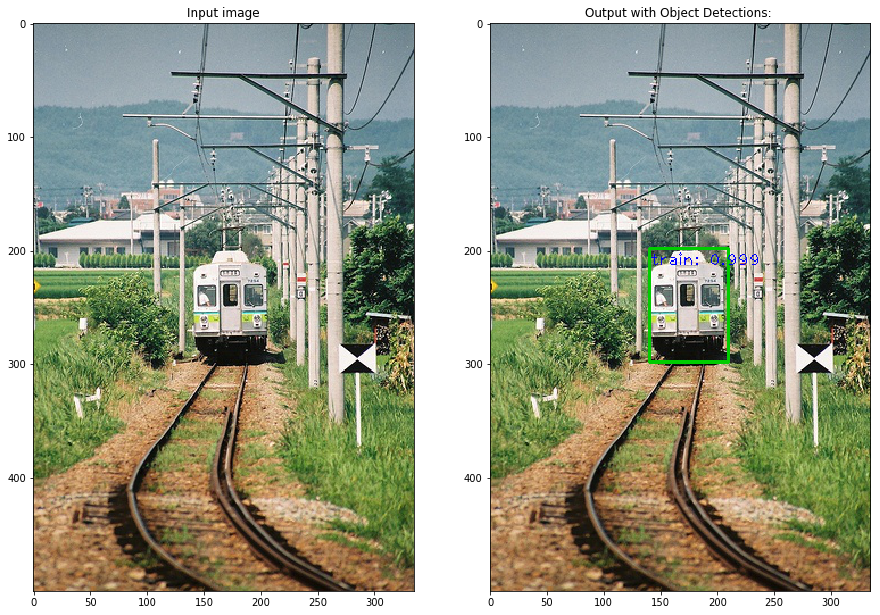

In [6]:
    torch.cuda.empty_cache()
    start = time.time()   
    max_per_image = 100
    thresh = 0.05
    im_in = np.array(imread('./images/img2.jpg'))
    im_out, cls_seen = process_image(im_in)
    end = time.time()
    print("Time taken for a single frame: ", end-start, "seconds")
    
    fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(15,16))
    axes[0].imshow(im_in, cmap = 'Greys')
    axes[0].set_title("Input image")
    axes[1].imshow(im_out, cmap ='Greys')
    axes[1].set_title("Output with Object Detections: ")
    plt.show()
    
    

In [9]:
from moviepy.editor import ipython_display

In [12]:
#  To process videos for Faster RCNN
white_output = 'output.mp4'
clip1 = VideoFileClip("camera_1.mp4")
white_clip = clip1.fl_image(process_frame) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)
clip1.ipython_display(t=10)
white_clip.ipython_display(t=10)

RuntimeError: cuda runtime error (2) : out of memory at /pytorch/aten/src/THC/generic/THCStorage.cu:58

In [ ]:
print("Frame from orginal video at t=15 s")
clip1.ipython_display(t=15, width=500)

In [ ]:
print("Frame from processed video at t=15 s")
white_clip.ipython_display(t=15, width=500, interactive=True)